# 3D Reconstruction
Now that we have the silhuettes we can now extract the visual hull of the object. Do so we need the camera intrinsic parameters and the extrinsic paramters. Our simulation pipeline already provides us with a json file for that. A python script then can be ran to extract the camera intrinsics

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from src.camera_data import CamerasData
from src.scans import Scans
from src.mesh import build_mesh

## 1. Data Classes
To do the reconstruction we need to organize our data into clear but usefull classes. This will include our Camera Data (`CameraData`) and our Pictures (`Scans`)

### 1.1. Camera Data
For the reconstruction we need:
- Camera Intrinsics
- Extrinsics Parameters

The camera intrinsics are defined by the matrix K and the extrinsics are defined by the individual camera positions (4x4 matrix). All of this is managed by the class ```CameraData```

In [3]:
camera_data = CamerasData("../blender_simulator/simulated_frames/dataset_d30/camera_intrinsics.json", "../blender_simulator/simulated_frames/dataset_d30/transforms_train.json")

In [4]:
print(f"K Matrix:\n{camera_data.K}\n")
print(f'Extrinsic Matrix of Camera 0\n{camera_data.get_camera_extrinsics(0)}\n')
print(f'With shape: {camera_data.extrinsics_array.shape}')

K Matrix:
[[2.66666667e+03 0.00000000e+00 9.60000000e+02]
 [0.00000000e+00 2.25000000e+03 5.40000000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Extrinsic Matrix of Camera 0
[[ 1.  0.  0.  0.]
 [ 0.  0. -1. -1.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  0.  1.]]

With shape: (12, 4, 4)


**Projection Matrix**<br>
By combining both matrices we can have the projection matrix

In [5]:
P = camera_data.P(0)

print(f'Projection Matyrix of Camera 0\n{P}\n')
print(f'With shape: {P.shape}')

Projection Matyrix of Camera 0
[[ 2.66666667e+03  9.60000000e+02  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  5.40000000e+02 -2.25000000e+03 -2.25000000e+03]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00]]

With shape: (3, 4)


### 1.2 Scans
Scans should have all the segemntations from the pictures taken. It holds the data as a binary array [0 or 1]

In [6]:
scans = Scans("../3d_reconstruction/figures/reconstruction_d30/segmented")

Number of scans: 12
Dimension of each scan: (1080, 1920)
Values in the first scan: [0 1]


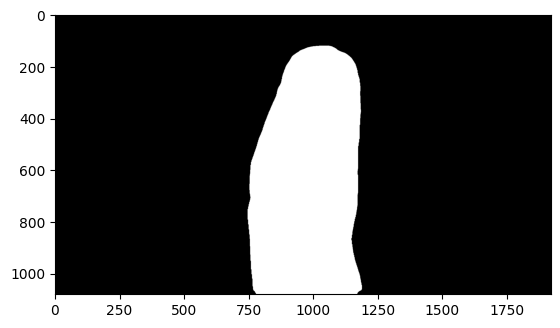

In [9]:
print(f"Number of scans: {scans.nr_positions}")
print(f"Dimension of each scan: {scans.scan_shape}")
print(f"Values in the first scan: {np.unique(scans.scan(0))}")

plt.imshow(scans.scan(0), cmap='gray')

## Convex Hull
This will take the data and apply the convex hull algorithm. In the simulated environment, the interest zone can be defined as a grid of `resolution` that goes from **-0.5m** to **0.5m** in every axis.

K:
 [[2.66667e+03 0.00000e+00 9.60000e+02]
 [0.00000e+00 2.25000e+03 5.40000e+02]
 [0.00000e+00 0.00000e+00 1.00000e+00]] 

Extrinsics:
 [[ 1.  0.  0.  0.]
 [ 0.  0. -1. -1.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  0.  1.]] 

P:
 [[ 2.66667e+03  9.60000e+02  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  5.40000e+02 -2.25000e+03 -2.25000e+03]
 [ 0.00000e+00  1.00000e+00  0.00000e+00  0.00000e+00]] 



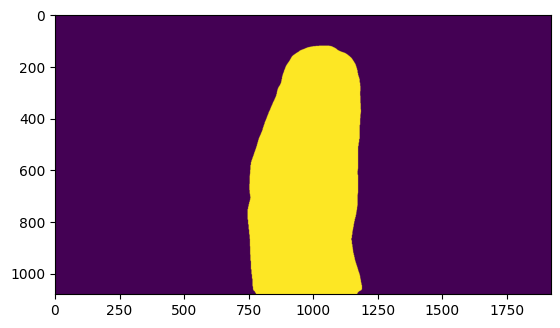

In [12]:
camera_nr = 0

P = camera_data.P(camera_nr)
K = camera_data.K
middle = np.zeros((3,4)) 
middle[:3, :3] = np.eye(3)
extrinsics = camera_data.get_camera_extrinsics(camera_nr)

print("K:\n", np.round(K,2), "\n")
print("Extrinsics:\n", extrinsics, "\n")
print("P:\n", np.round(P,2), "\n")
plt.imshow(scans.scan(0))

In [15]:
x1, x2, x3 = P @ np.array([0,0,0,1])
print(f"X1 : {x1}, X2 : {x2}, X3 : {x3}")
print(x1/x3, x2/x3)

X1 : 0.0, X2 : -2250.0, X3 : 0.0
nan -inf


/var/folders/bf/r_50r8qd15b63xr26n0_ts640000gn/T/ipykernel_3864/2572951376.py:3: RuntimeWarning: invalid value encountered in scalar divide
  print(x1/x3, x2/x3)
/var/folders/bf/r_50r8qd15b63xr26n0_ts640000gn/T/ipykernel_3864/2572951376.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  print(x1/x3, x2/x3)


In [164]:
# Get the pseudo-inverse of the projection matrix
P_inv = np.linalg.pinv(P)
u, v = 0,0

# Convert 2D point back to 3D (assuming depth = 1)
point_2d_homogeneous = np.array([u, v, 1])
point_3d_recovered = P_inv @ point_2d_homogeneous

# Normalize by the homogeneous coordinate if needed
if point_3d_recovered[3] != 0:
    point_3d_recovered = point_3d_recovered[:3] / point_3d_recovered[3]
else:
    point_3d_recovered = point_3d_recovered[:3]

print(f"Recovered 3D point: {point_3d_recovered}")
start_range = point_3d_recovered

Recovered 3D point: [-3.00377579  8.34666504  0.8688871 ]


In [197]:
scans.scan_shape

(1080, 1920)

[[ 2.29617516e+03  9.40467212e+02 -1.36960311e+03 -1.33301910e+03]
 [-1.14411101e+03  5.12177360e+02 -1.94493817e+03 -1.94822332e+03]
 [-4.65661287e-10  9.99897361e-01 -1.43322209e-02  0.00000000e+00]]


In [403]:
camera_nr = 0
P = camera_data.P(camera_nr)

K = np.round(camera_data.K, 2).astype(np.float32)
middle = np.zeros((3,4)) 
middle[:3, :3] = np.eye(3)
extrinsics = camera_data.get_camera_extrinsics(camera_nr)
rotation = extrinsics[:3, :3]
translation = extrinsics[:3, 3]

print("K:\n", np.round(K,2), "\n")
print("Middle: \n", middle, "\n")
print("Extrinsics:\n", extrinsics, "\n")
print("Rotation:\n", rotation, "\n")
print("Translation:\n", translation, "\n")

print(K @ middle)

new_P = K @ middle @ extrinsics
print("New P:\n", new_P, "\n")
print("Old P:\n", P, "\n")

print("Old Vs New P are close?: ", np.allclose(P, new_P), "\n")

print("P's Spectral Norm:", np.linalg.norm(P, 2))



K:
 [[2.66667e+03 0.00000e+00 9.60000e+02]
 [0.00000e+00 2.25000e+03 5.40000e+02]
 [0.00000e+00 0.00000e+00 1.00000e+00]] 

Middle: 
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]] 

Extrinsics:
 [[ 9.99992847e-01  5.45056282e-05  3.79700959e-03  0.00000000e+00]
 [ 3.79740074e-03 -1.43533014e-02 -9.99889851e-01 -1.00000000e+00]
 [-3.63797881e-12  9.99897003e-01 -1.43534066e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] 

Rotation:
 [[ 9.99992847e-01  5.45056282e-05  3.79700959e-03]
 [ 3.79740074e-03 -1.43533014e-02 -9.99889851e-01]
 [-3.63797881e-12  9.99897003e-01 -1.43534066e-02]] 

Translation:
 [ 0. -1.  0.] 

[[2.66666992e+03 0.00000000e+00 9.60000000e+02 0.00000000e+00]
 [0.00000000e+00 2.25000000e+03 5.40000000e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]]
New P:
 [[ 2.66665085e+03  9.60046472e+02 -3.65389909e+00  0.00000000e+00]
 [ 8.54415167e+00  5.07649454e+02 -2.25750300e+03 -2.25000000e+03]
 [-3.

In [422]:
x1, x2, x3 = new_P @ np.array([0,0,25000,1])
print(x1/x3, x2/x3)

254.56668157659237 157286.2153164944


(1080, 1920)


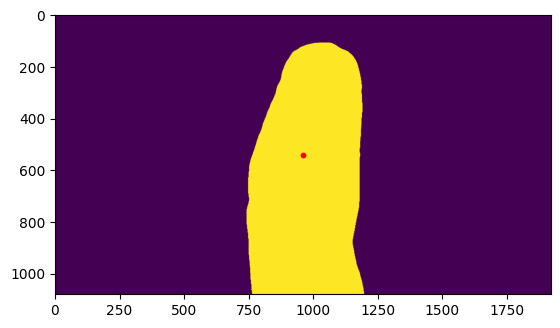

In [413]:
plt.imshow(scans.scan(0))
plt.scatter(scans.scan_shape[1]//2, scans.scan_shape[0]//2, color='red', s=10)
print(scans.scan_shape)

In [295]:
# Get the pseudo-inverse of the projection matrix
P_inv = np.linalg.pinv(P)
u, v = 1080, 1920

# Convert 2D point back to 3D (assuming depth = 1)
point_2d_homogeneous = np.array([u, v, 1])
point_3d_recovered = P_inv @ point_2d_homogeneous

# Normalize by the homogeneous coordinate if needed
if point_3d_recovered[3] != 0:
    point_3d_recovered = point_3d_recovered[:3] / point_3d_recovered[3]
else:
    point_3d_recovered = point_3d_recovered[:3]

print(f"Recovered 3D point: {point_3d_recovered}")
end_range = point_3d_recovered

Recovered 3D point: [-0.15053548 -3.24618854  1.04613727]


In [299]:
point_3d_recovered = [point_3d_recovered[0], point_3d_recovered[1], point_3d_recovered[2], 1]
np.round(P @ point_3d_recovered).astype(int)

array([-3522, -6261,    -3])

In [289]:
# GENERATE GRID OF 3D POINTS
# [-3.00377579  8.34666504  0.8688871 ]
# [-0.15053548 -3.24618854  1.04613727]
start_range = np.array([-1.17937123,  0.06638487, -2.18180192])
end_range = np.array([1.17907361, 1.93505969, 0.13677393])

resolution = 50
range_value = 0.5
x_range = np.sort(np.linspace(start_range[0], end_range[0], resolution))
y_range = np.sort(np.linspace(start_range[0], end_range[0], resolution))
z_range = np.sort(np.linspace(start_range[0], end_range[0], resolution))

X, Y, Z = np.meshgrid(x_range, y_range, z_range)

In [389]:
# GENERATE GRID OF 3D POINTS
# [-3.00377579  8.34666504  0.8688871 ]
# [-0.15053548 -3.24618854  1.04613727]
resolution = 25
range_value = 1
x_range = np.linspace(-range_value, range_value, resolution)
y_range = np.linspace(-range_value, range_value, resolution)
z_range = np.linspace(-range_value, range_value, resolution)

X, Y, Z = np.meshgrid(x_range, y_range, z_range)

In [390]:
print(camera_data.get_camera_extrinsics(1))

[[ 8.61065686e-01 -7.28784548e-03 -5.08441567e-01 -4.99882162e-01]
 [-5.08493781e-01 -1.23409843e-02 -8.60977232e-01 -8.65877032e-01]
 [-4.65661287e-10  9.99897361e-01 -1.43322209e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [391]:
test_array = np.zeros((resolution, resolution, resolution, 3))
for i, x in enumerate(x_range):
    for j, y in enumerate(y_range):
        for k, z in enumerate(z_range):
            test_array[i, j, k] = np.array([x, y, z])

In [392]:
# Find position where test_array has the value [-1, -1, -1]
target_value = np.array([-1, -1, -1])
positions = np.array(np.where(np.all(test_array == target_value, axis=3))).ravel()
print(f"Positions where test_array equals {target_value}:")
print(positions)

Positions where test_array equals [-1 -1 -1]:
[0 0 0]


In [393]:
camera_volume = np.zeros(X.shape, dtype=int)
target_camera = 0
P = camera_data.P(target_camera)
has_printed = False
found_points = []

for x in x_range:
    for y in y_range:
        for z in z_range:
            point_3d = np.array([x, y, z, 1])
            x1, x2, x3 = np.round(P @ point_3d).astype(int)
            if x3 == 0: continue
            u = x1 // x3
            v = x2 // x3
            found_points.append((u,v))
            if 0 <= u < scans.scan_shape[0] and 0 <= v < scans.scan_shape[1]:
                position = np.array(np.where(np.all(test_array == np.array([x,y,z]), axis=3))).ravel()
                scan_value = scans.scan(target_camera)[u, v]
                if scan_value > 0 and not has_printed:
                    print(x,y,z)
                    print(position)
                    print(scan_value)
                    has_printed = True
                camera_volume[position] += scan_value

camera_volume = np.where(camera_volume > 0, 1, 0)

-0.16666666666666674 -0.5833333333333334 -0.75
[10  5  3]
1


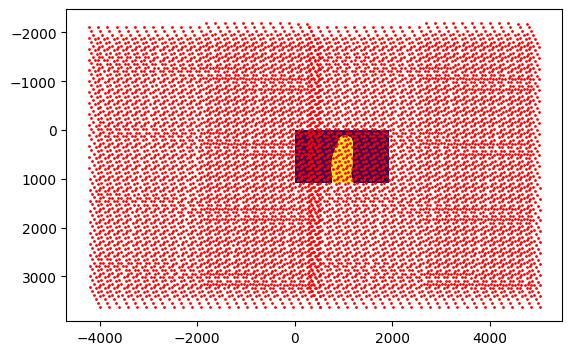

In [394]:
import matplotlib.pyplot as plt
plt.imshow(scans.scan(0))
plt.scatter([v for u,v in found_points], [u for u,v in found_points], color='red', s=1)

In [395]:
print(camera_volume.shape)

(25, 25, 25)


In [396]:
np.unique(camera_volume)

array([0, 1])

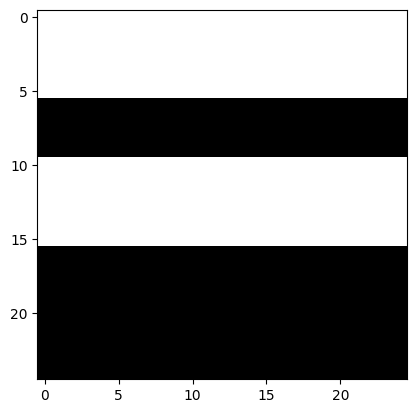

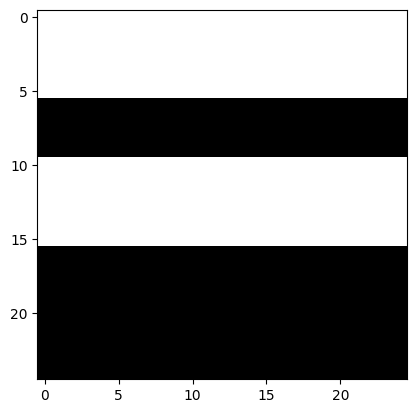

In [400]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(camera_volume[:, :, resolution // 2], cmap='gray')
plt.figure()
plt.imshow(camera_volume[:, resolution // 2, :], cmap='gray')
plt.figure()
plt.imshow(camera_volume[resolution // 2+10, :, :], cmap='gray')

In [275]:
#camera_volume = np.zeros(X.shape, dtype=int) + np.random.randint(0, 2, size=X.shape)
build_mesh(camera_volume, file_name="camera_volume_mesh.ply")

âœ… Finished exporting blender/camera_volume_mesh.ply
Mesh vertices: 5000, faces: 9604


<trimesh.Trimesh(vertices.shape=(5000, 3), faces.shape=(9604, 3))>

In [52]:
np.linspace(-0.1, 0.1, resolution)

array([-0.1       , -0.09591837, -0.09183673, -0.0877551 , -0.08367347,
       -0.07959184, -0.0755102 , -0.07142857, -0.06734694, -0.06326531,
       -0.05918367, -0.05510204, -0.05102041, -0.04693878, -0.04285714,
       -0.03877551, -0.03469388, -0.03061224, -0.02653061, -0.02244898,
       -0.01836735, -0.01428571, -0.01020408, -0.00612245, -0.00204082,
        0.00204082,  0.00612245,  0.01020408,  0.01428571,  0.01836735,
        0.02244898,  0.02653061,  0.03061224,  0.03469388,  0.03877551,
        0.04285714,  0.04693878,  0.05102041,  0.05510204,  0.05918367,
        0.06326531,  0.06734694,  0.07142857,  0.0755102 ,  0.07959184,
        0.08367347,  0.0877551 ,  0.09183673,  0.09591837,  0.1       ])

In [80]:
results

[array([ -362., -2076.]),
 array([ -362., -2085.]),
 array([ -362., -2094.]),
 array([ -362., -2104.]),
 array([ -362., -2113.]),
 array([ -362., -2122.]),
 array([ -362., -2131.]),
 array([ -362., -2140.]),
 array([ -362., -2150.]),
 array([ -362., -2159.]),
 array([ -362., -2168.]),
 array([ -362., -2177.]),
 array([ -362., -2186.]),
 array([ -362., -2196.]),
 array([ -363., -2205.]),
 array([ -363., -2214.]),
 array([ -363., -2223.]),
 array([ -363., -2233.]),
 array([ -363., -2242.]),
 array([ -363., -2251.]),
 array([ -363., -2260.]),
 array([ -363., -2269.]),
 array([ -363., -2279.]),
 array([ -363., -2288.]),
 array([ -363., -2297.]),
 array([ -363., -2306.]),
 array([ -363., -2315.]),
 array([ -363., -2325.]),
 array([ -363., -2334.]),
 array([ -363., -2343.]),
 array([ -363., -2352.]),
 array([ -363., -2362.]),
 array([ -363., -2371.]),
 array([ -363., -2380.]),
 array([ -363., -2389.]),
 array([ -363., -2398.]),
 array([ -363., -2408.]),
 array([ -363., -2417.]),
 array([ -36

In [81]:
np.array(results).shape

(125000, 2)

In [82]:
np.max(np.unique(results, axis=0))

np.float64(363.0)

In [278]:
Ps = []
for i in range(camera_data.nr_cameras):
    P = camera_data.P(i)
    Ps.append(P)
Ps = np.array(Ps)

In [279]:
def estimate_extent(Ps, image_size, near=0.1, far=2.0):
    W, H = image_size
    corners_2d = np.array([[0,0], [W,0], [0,H], [W,H]])
    pts_world = []

    for P in Ps:
        # camera center (null space of P)
        _, _, Vt = np.linalg.svd(P)
        C = Vt[-1]
        C = C[:3] / C[3]

        # direction vectors for each corner ray
        KRt = P[:, :3]
        dirs = []
        for (u,v) in corners_2d:
            ray_cam = np.linalg.inv(KRt) @ np.array([u, v, 1.0])
            ray_cam /= np.linalg.norm(ray_cam)
            dirs.append(ray_cam)

        dirs = np.stack(dirs)
        # generate near/far points
        for d in dirs:
            pts_world.append(C + d * near)
            pts_world.append(C + d * far)

    pts_world = np.stack(pts_world)
    return pts_world.min(axis=0), pts_world.max(axis=0)


In [280]:
estimate_extent(Ps, scans.scan_shape)

(array([-1.17937123,  0.06638487, -2.18180192]),
 array([1.17907361, 1.93505969, 0.13677393]))

In [ ]:
# GENERATE GRID OF 3D POINTS
# [-3.00377579  8.34666504  0.8688871 ]
# [-0.15053548 -3.24618854  1.04613727]
resolution = 50
range_value = 1.5
x_range = np.linspace(-range_value, range_value, resolution)
y_range = np.linspace(-range_value, range_value, resolution)
z_range = np.linspace(-range_value, range_value, resolution)

X, Y, Z = np.meshgrid(x_range, y_range, z_range)